# [How to use a stateful LSTM model, stateful vs stateless LSTM performance comparison](https://keras.io/examples/lstm_stateful/)

- The models are trained on an input/output pair, where the input is a generated uniformly distributed random sequence of length = `input_len`, and the output is a moving average of the input with window length = `tsteps`. Both `input_len` and `tsteps` are defined in the "editable parameters" section.

- A larger `tsteps` value means that the LSTM will need more memory to figure out the input-output relationship. This memory length is controlled by the `lahead` variable (more details below).

- The rest of the parameters are:

    - `input_len`: the length of the generated input sequence
    - `lahead`: the input sequence length that the LSTM is trained on for each output point
    - `batch_size`, `epochs`: same parameters as in the model.fit(...) function


- When `lahead > 1`, the model input is preprocessed to a "rolling window view" of the data, with the window length = `lahead`. This is similar to sklearn's view_as_windows with window_shape being a single number.

- When `lahead < tsteps`, only the stateful LSTM converges because its statefulness allows it to see beyond the capability that `lahead` gave it to fit the n-point average. The stateless LSTM does not have this capability, and hence is limited by its `lahead` parameter, which is not sufficient to see the n-point average.

- When `lahead >= tsteps`, both the stateful and stateless LSTM converge.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load packages.
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import r2_score

%matplotlib inline

Using TensorFlow backend.


In [3]:
# ----------------------------------------------------------
# EDITABLE PARAMETERS
# Read the documentation in the script head for more details
# ----------------------------------------------------------

np.random.seed(42)

# Length of input.
input_len = 1000

# The window length of the moving average used to generate the output from the input in the 
# input/output pair used to train the LSTM.
# e.g. if tsteps=2 and input=[1, 2, 3, 4, 5],
#      then output=[1.5, 2.5, 3.5, 4.5]
tsteps = 6

# The input sequence length that the LSTM is trained on for each output point. Number of 
# time steps.
lahead = 3

# Training parameters passed to "model.fit(...)"
batch_size = 1
epochs = 10

*********************************
STATELESS LSTM WILL NOT CONVERGE
*********************************

>>> Generating Data...

>>> Input shape: (1000, 3)

>>> Output shape: (1000, 1)

>>> Input head: 
          0         1         2
5 -0.068801 -0.068796  0.019732
6 -0.088383 -0.068801 -0.068796
7  0.073235 -0.088383 -0.068801
8  0.020223  0.073235 -0.088383
9  0.041615  0.020223  0.073235

>>> Output head: 
          0
5 -0.001069
6 -0.011618
7 -0.014436
8 -0.018798
9 -0.015151

>> Input tail: 
             0         1         2
1000 -0.062973 -0.010799  0.090047
1001  0.008380 -0.062973 -0.010799
1002  0.074589  0.008380 -0.062973
1003  0.046445  0.074589  0.008380
1004  0.061312  0.046445  0.074589

>>> Output tail: 
             0
1000 -0.009097
1001  0.005914
1002  0.004435
1003  0.024282
1004  0.019492

>>> Plotting input and expected output ...


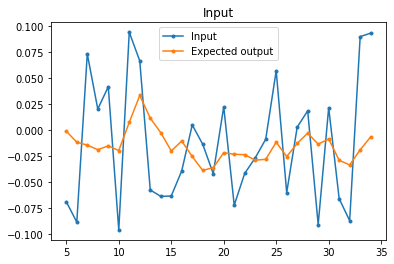


>>> x_train.shape:  (800, 3, 1)

>>> y_train.shape:  (800, 1)

>>> x_test.shape:  (200, 3, 1)

>>> y_test.shape:  (200, 1)

>>> Creating Stateful Model ...





>>> Training ...
Epoch 1 / 10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 3ms/step - loss: 1.2301e-04 - val_loss: 9.0847e-05
Epoch 2 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 2s 3ms/step - loss: 7.8926e-05 - val_loss: 9.3371e-05
Epoch 3 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 2s 3ms/step - loss: 8.2252e-05 - val_loss: 9.7152e-05
Epoch 4 / 10
Train on 800 samples, validate on 200 samples
Epoch 1/1
800/800 [==============================] - 3s 3ms/step - loss: 8.4394e-05 - val_loss: 1.0103e-04
Epoch 5 / 10
Train on 800 samples, validate on 200 samples
Ep

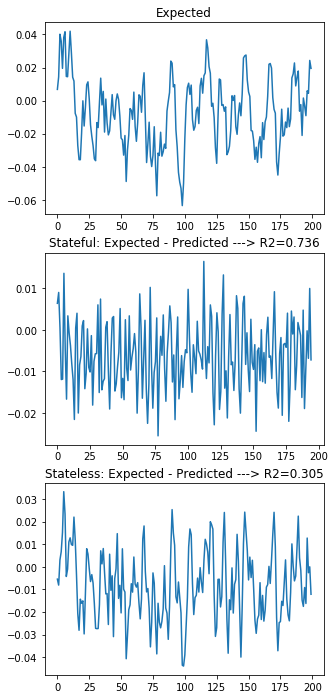

CPU times: user 1min 15s, sys: 5 s, total: 1min 20s
Wall time: 47.8 s


In [4]:
%%time

# ------------
# MAIN PROGRAM
# ------------

print("*" * 33)
if lahead >= tsteps:
    print("STATELESS LSTM WILL ALSO CONVERGE")
else:
    print("STATELESS LSTM WILL NOT CONVERGE")
print("*" * 33)

print("\n>>> Generating Data...")

def gen_uniform_amp(amp=1, xn=10000):
    """
    Generates uniform random data betweew -amp and +amp and of length xn.

    # Arguments
        amp: maximum/minimum range of uniform data
        xn: length of series
    """
    data_input = np.random.uniform(-1 * amp, +1 * amp, xn)
    data_input = pd.DataFrame(data_input)
    return data_input

# Since the output is a moving average of the input, the first few points of output will be 
# NaN and will be dropped from the generated data before training the LSTM. Also, when 
# lahead > 1, the preprocessing step later of "rolling window view" will also cause some 
# points to be lost. For aesthetic reasons, in order to maintain generated data length = 
# input_len after pre-processing, add a few points to account for the values that will be 
# lost.
to_drop = max(tsteps - 1, lahead - 1)
data_input = gen_uniform_amp(amp=0.1, xn=input_len + to_drop)

# Set the target to be a N-point average of the input.
expected_output = data_input.rolling(window=tsteps, center=False).mean()

# When lahead > 1, need to convert the input to "rolling window view"
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.repeat.html
if lahead > 1:
    data_input = np.repeat(data_input.values, repeats=lahead, axis=1)
    data_input = pd.DataFrame(data_input)
    for i, c in enumerate(data_input.columns):
        data_input[c] = data_input[c].shift(i)
        
# Drop the nan.
expected_output = expected_output[to_drop:]
data_input = data_input[to_drop:]        

print("\n>>> Input shape:", data_input.shape)
print("\n>>> Output shape:", expected_output.shape)
print("\n>>> Input head: ")
print(data_input.head())
print("\n>>> Output head: ")
print(expected_output.head())
print("\n>> Input tail: ")
print(data_input.tail())
print("\n>>> Output tail: ")
print(expected_output.tail())

print("\n>>> Plotting input and expected output ...")
plt.plot(data_input[0][:30], ".-")
plt.plot(expected_output[0][:30], ".-")
plt.legend(["Input", "Expected output"])
plt.title("Input")
plt.show()

def create_model(stateful):
    model = Sequential()
    model.add(LSTM(20,
              input_shape=(lahead, 1),
              batch_size=batch_size,
              stateful=stateful))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    return model

# Split train/test data.
def split_data(x, y, ratio=0.8):
    to_train = int(input_len * ratio)
    # Tweak to match with batch_size.
    to_train -= to_train % batch_size

    x_train = x[:to_train]
    y_train = y[:to_train]
    x_test = x[to_train:]
    y_test = y[to_train:]

    # Tweak to match with batch_size.
    to_drop = x.shape[0] % batch_size
    if to_drop > 0:
        x_test = x_test[:-1 * to_drop]
        y_test = y_test[:-1 * to_drop]

    # Some reshaping.
    reshape_3 = lambda x: x.values.reshape((x.shape[0], x.shape[1], 1))
    x_train = reshape_3(x_train)
    x_test = reshape_3(x_test)

    reshape_2 = lambda x: x.values.reshape((x.shape[0], 1))
    y_train = reshape_2(y_train)
    y_test = reshape_2(y_test)

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = split_data(data_input, expected_output)
print("\n>>> x_train.shape: ", x_train.shape)
print("\n>>> y_train.shape: ", y_train.shape)
print("\n>>> x_test.shape: ", x_test.shape)
print("\n>>> y_test.shape: ", y_test.shape)

print("\n>>> Creating Stateful Model ...")
model_stateful = create_model(stateful=True)

print("\n>>> Training ...")

for i in range(epochs):
    print("Epoch", i + 1, "/", epochs)
    # Note that the last state for sample i in a batch will be used as initial state for 
    # sample i in the next batch. Thus we are simultaneously training on batch_size 
    # series with lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be extracted with 
    # data_input[i::batch_size].
    model_stateful.fit(x_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=1,
                       verbose=1,
                       validation_data=(x_test, y_test),
                       shuffle=False)
    model_stateful.reset_states()

print("\n>>> Predicting ...")
predicted_stateful = model_stateful.predict(x_test, batch_size=batch_size)

print("\n>>> Creating Stateless Model ...")
model_stateless = create_model(stateful=False)

print("\n>>> Training ...")
model_stateless.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    shuffle=False)

print("\n>>> Predicting ...")
predicted_stateless = model_stateless.predict(x_test, batch_size=batch_size)

print("\n>>> Plotting Results ...")
plt.figure(figsize=(5, 12))
plt.subplot(3, 1, 1)
plt.plot(y_test)
plt.title("Expected")
plt.subplot(3, 1, 2)
# Drop the first "tsteps-1" because it is not possible to predict them
# since the "previous" timesteps to use do not exist;
plt.plot((y_test - predicted_stateful).flatten()[tsteps - 1:])
plt.title("Stateful: Expected - Predicted ---> R2=%.3f" 
          %(r2_score(y_test.flatten()[tsteps - 1:], predicted_stateful.flatten()[tsteps - 1:])))
plt.subplot(3, 1, 3)
plt.plot((y_test - predicted_stateless).flatten())
plt.title("Stateless: Expected - Predicted ---> R2=%.3f" 
         %(r2_score(y_test.flatten(), predicted_stateless.flatten())))
plt.show()